In [1]:
from sklearn.manifold import TSNE
import os
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.utils import compute_sample_weight
import seaborn as sns

from lib.preprocess import Preprocess

In [2]:
def mean_f1score(preds:np.ndarray,eval_data: lgb.Dataset):
    y_true = eval_data.get_label()
    weight = eval_data.get_weight()
    preds = preds.reshape(len(np.unique(y_true)), -1)
    preds = preds.argmax(axis = 0)
    f1 = f1_score(y_true,preds,average='macro',sample_weight=weight)
    return 'f1',f1,True

In [3]:
SEED = 314
datasrc = "data/official/"
data = pd.read_csv(os.path.join(datasrc, "train.csv"), index_col=0)

train, valid = train_test_split(data, test_size=0.2, random_state=42, stratify=data["health"])

# %%
x_train = train.drop("health", axis=1)
y_train = train["health"]
x_valid = valid.drop("health", axis=1)
y_valid = valid["health"]

In [4]:
ignore_columns = [
    "nta_name",
    "boro_ct",
    "spc_latin",
]
# get object columns
object_columns = [col for col in x_train.select_dtypes(include=["object"]).columns.tolist() if col not in ignore_columns]
config = {
    "object_columns": object_columns,
}
preprocess = Preprocess(config)

In [5]:
train_index = x_train.index
valid_index = x_valid.index

x_train = preprocess.fit_transform(x_train, y_train)
x_valid = preprocess.transform(x_valid)

x_train = pd.DataFrame(x_train, index=train_index, columns=preprocess.get_feature_names_out())
x_valid = pd.DataFrame(x_valid, index=valid_index, columns=preprocess.get_feature_names_out())

x_train = x_train.fillna(-10)
x_valid = x_valid.fillna(-10)

In [6]:
raw_tsne = TSNE(n_components=2, random_state=SEED)
tsne_raw_train_results = raw_tsne.fit_transform(x_train)

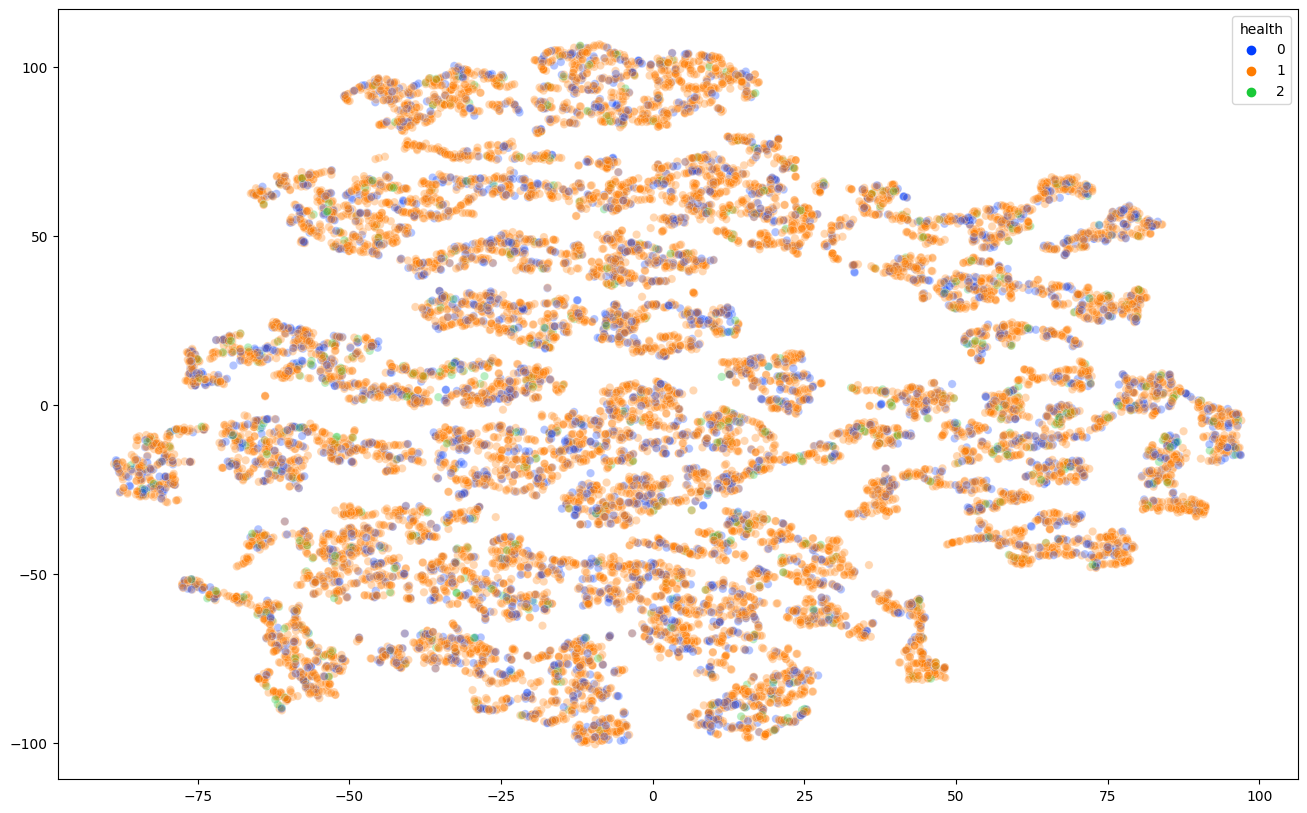

In [7]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_raw_train_results[:, 0], y=tsne_raw_train_results[:, 1],
    hue=y_train,
    color="black",
    palette="bright",
    legend="full",
    alpha=0.3
)
plt.show()

In [8]:
raw_tsne = TSNE(n_components=2, random_state=SEED)
tsne_raw_valid_results = raw_tsne.fit_transform(x_valid)

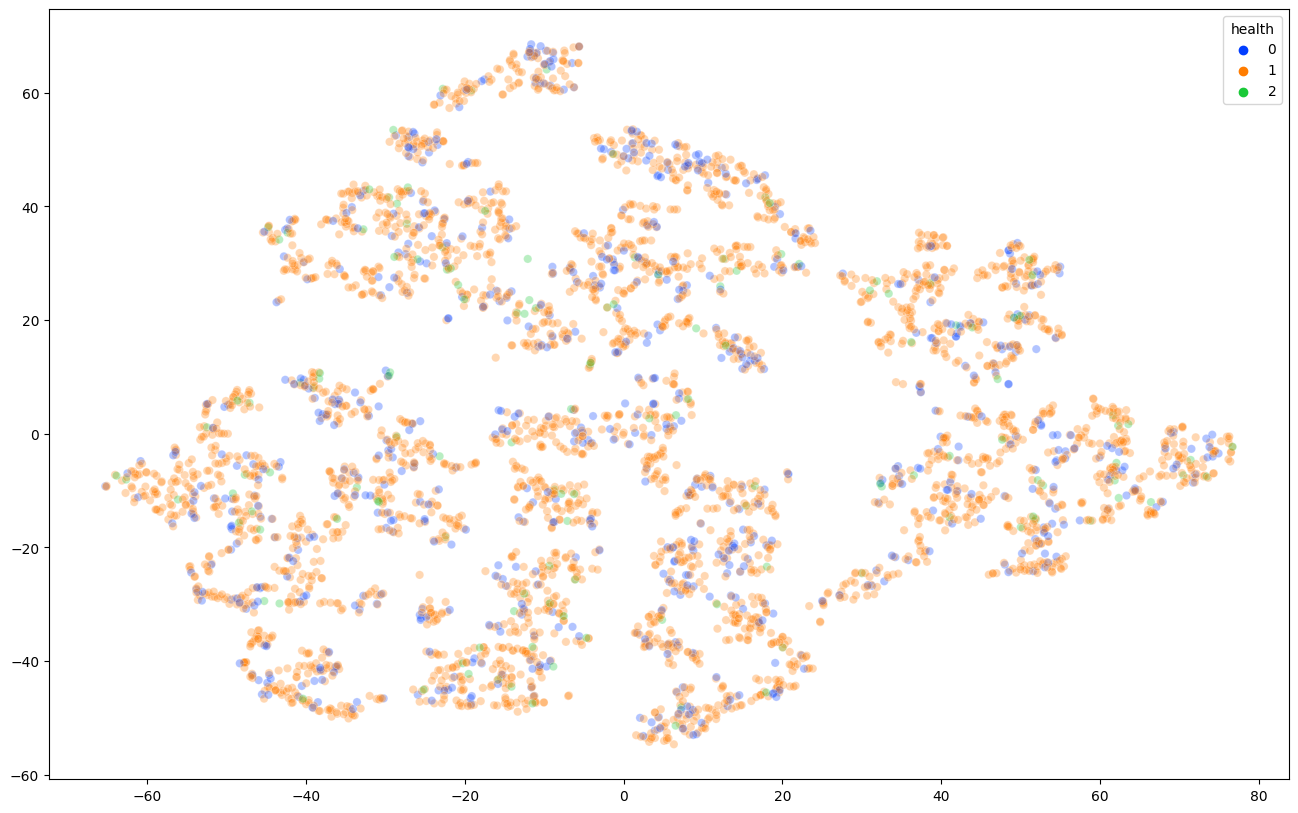

In [9]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_raw_valid_results[:, 0], y=tsne_raw_valid_results[:, 1],
    hue=y_valid,
    color="black",
    palette="bright",
    legend="full",
    alpha=0.3
)
plt.show()

In [10]:
lgb_train = lgb.Dataset(x_train, y_train, weight=compute_sample_weight(class_weight='balanced',y=y_train))
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

params = {
    'objective': 'multiclass',
    'metric': None,
    'num_class': 3,
    'seed': SEED,
    'num_threads': -1,
}
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    # early_stopping_rounds=100,
    # verbose_eval=100,
    feval=mean_f1score,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        # lgb.reset_parameter(learning_rate=lambda current_round: 0.01 * 0.995 ** current_round),
    ]
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2636
[LightGBM] [Info] Number of data points in the train set: 15987, number of used features: 46
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


In [11]:
train_preds = model.predict(x_train)
valid_preds = model.predict(x_valid)

In [12]:
tsne = TSNE(n_components=2, random_state=SEED)
tsne_train_results = tsne.fit_transform(train_preds)

In [13]:
f1_score(y_train, train_preds.argmax(axis=1), average='macro')

0.5141627101905907

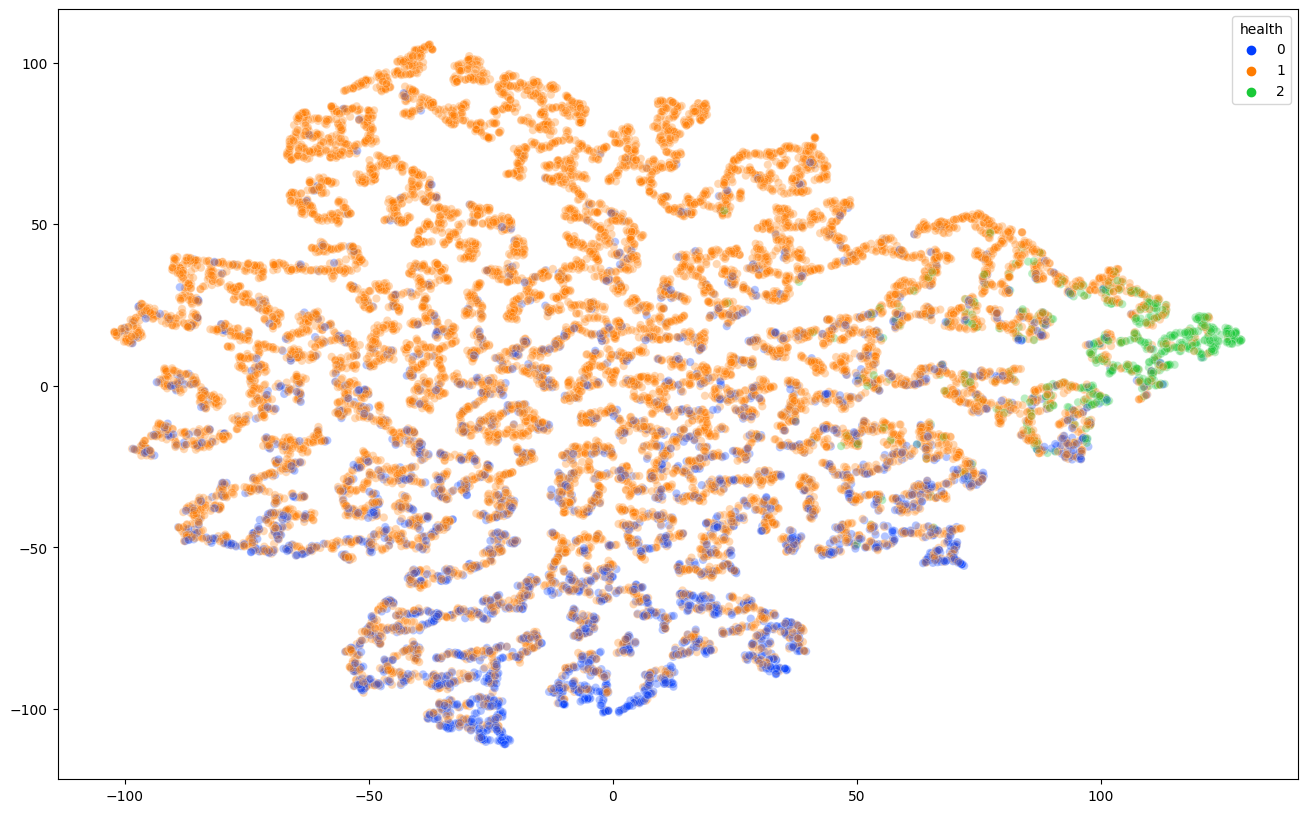

In [14]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_train_results[:, 0], y=tsne_train_results[:, 1],
    hue=y_train,
    color="black",
    palette="bright",
    legend="full",
    alpha=0.3
)
plt.show()

In [ ]:
tsne = TSNE(n_components=2, random_state=SEED)
tsne_valid_results = tsne.fit_transform(valid_preds)

In [ ]:
f1_score(y_valid, valid_preds.argmax(axis=1), average='macro')

0.32467210970867727

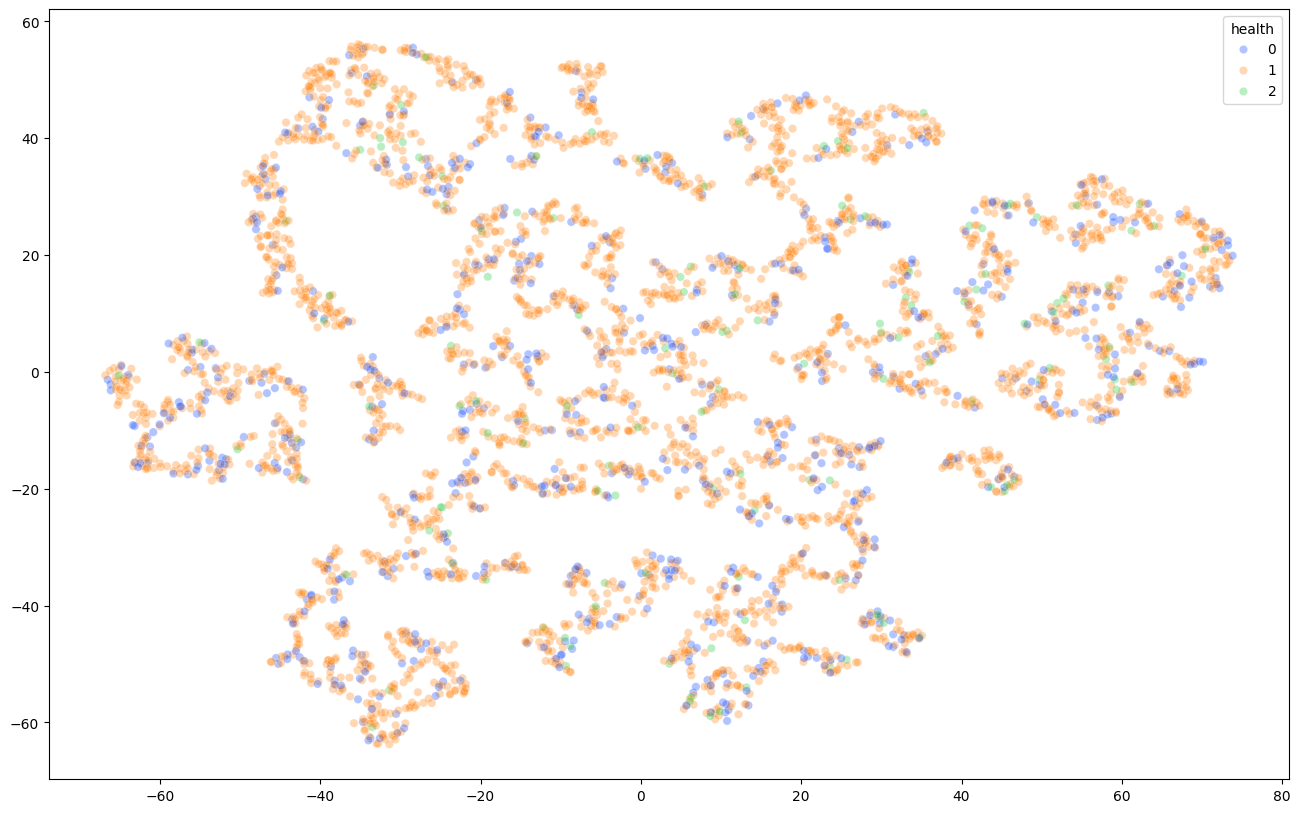

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_valid_results[:, 0], y=tsne_valid_results[:, 1],
    hue=y_valid,
    color="black",
    palette="bright",
    legend="full",
    alpha=0.3
)
plt.show()